## Multi-Interest Network with Dynamic Routing (MIMD)

下载并处理MovieLens-1M数据集...
下载MovieLens-1M数据集...
解压数据集...
读取和处理数据...
数据集信息: 物品数量=3953, 训练样本=6038, 验证样本=6038, 测试样本=6038
开始训练模型...


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  1%|          | 10/1000 [01:07<1:49:09,  6.62s/it]

Epoch 10/1000, Train Loss: 4.5808, Val Loss: 4.5882, LR: 0.005000
Evaluating model at epoch 10...


  2%|▏         | 20/1000 [02:14<1:48:20,  6.63s/it]

Epoch 20/1000, Train Loss: 4.5370, Val Loss: 4.5486, LR: 0.005000
Evaluating model at epoch 20...


  3%|▎         | 30/1000 [03:20<1:47:09,  6.63s/it]

Epoch 30/1000, Train Loss: 4.5368, Val Loss: 4.5477, LR: 0.005000
Evaluating model at epoch 30...


  4%|▍         | 40/1000 [04:26<1:44:41,  6.54s/it]

Epoch 40/1000, Train Loss: 4.5401, Val Loss: 4.5494, LR: 0.005000
Evaluating model at epoch 40...


  4%|▍         | 42/1000 [04:45<1:48:42,  6.81s/it]

早停在epoch 42


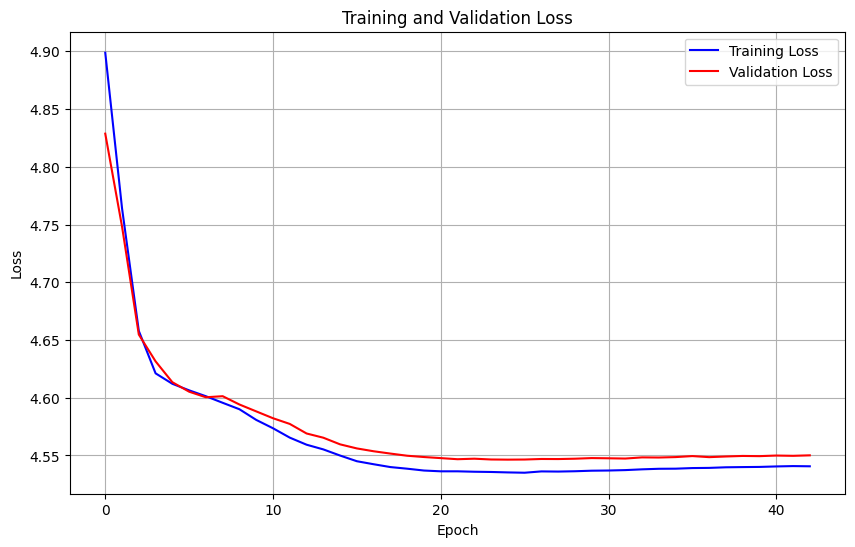

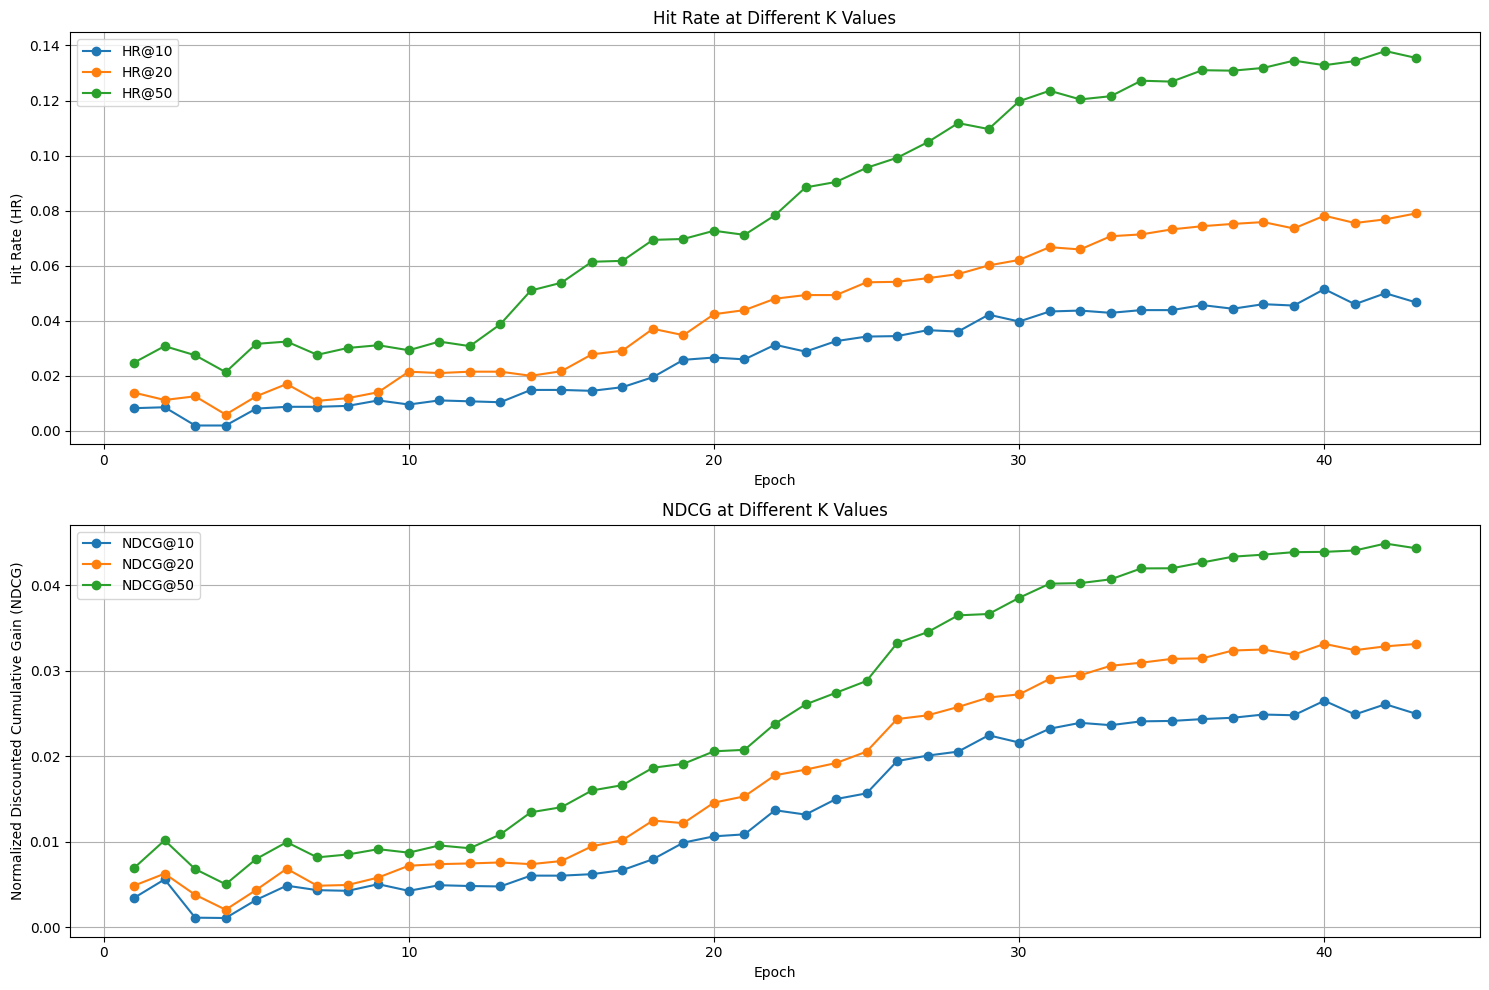

评估测试集性能...
HR@10: 0.0343, NDCG@10: 0.0156
HR@20: 0.0540, NDCG@20: 0.0205
HR@50: 0.0956, NDCG@50: 0.0288


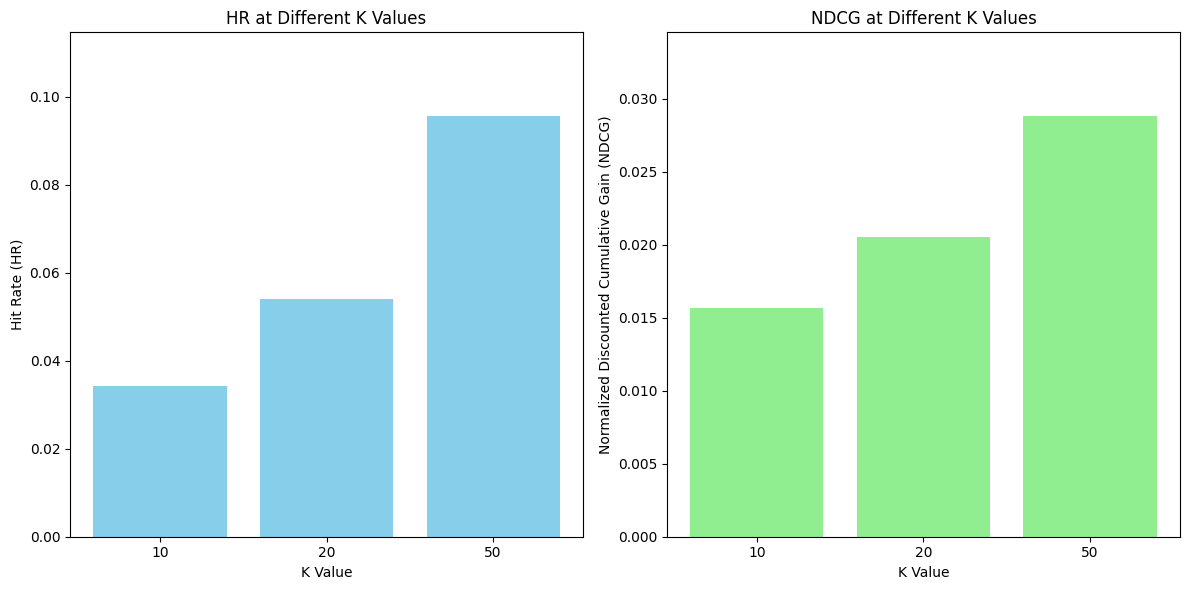

训练和评估完成!


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import zipfile
import requests
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.nn.init import xavier_uniform_
# 胶囊网络层
class CapsuleLayer(nn.Module):
    """胶囊网络层，实现B2I动态路由算法"""
    def __init__(self, input_units, out_units, max_len, k_max=4, iterations=3):
        super(CapsuleLayer, self).__init__()
        self.input_units = input_units
        self.out_units = out_units
        self.max_len = max_len
        self.k_max = k_max
        self.iterations = iterations
        self.shared_weights = nn.Parameter(torch.randn(1, input_units, out_units))
        
    def forward(self, inputs):
        history_emb, hist_len = inputs
        batch_size = history_emb.size(0)
        k_user = torch.clamp(torch.floor(torch.log2(hist_len.float())), min=1, max=self.k_max).long()
        b_ij = torch.randn(batch_size, self.max_len, self.k_max, device=history_emb.device)
        for i in range(self.iterations):
            c_ij = F.softmax(b_ij, dim=2)
            mask = torch.arange(self.max_len, device=hist_len.device).expand(batch_size, self.max_len) >= hist_len.unsqueeze(1)
            c_ij = c_ij.masked_fill(mask.unsqueeze(2), 0)
            u_hat = torch.matmul(history_emb, self.shared_weights)
            s_j = torch.bmm(c_ij.transpose(1, 2), u_hat)
            v_j = self.squash(s_j)
            if i < self.iterations - 1:
                u_v = torch.bmm(u_hat, v_j.transpose(1, 2))
                b_ij = b_ij + u_v
        
        final_v_j = []
        for i in range(batch_size):
            final_v_j.append(v_j[i, :k_user[i], :])
        max_k = k_user.max().item()
        output = torch.zeros(batch_size, max_k, self.out_units, device=history_emb.device)
        for i in range(batch_size):
            output[i, :k_user[i], :] = final_v_j[i]
        return output, k_user
    
    def squash(self, inputs):
        norm = torch.norm(inputs, p=2, dim=2, keepdim=True)
        norm_squared = norm ** 2
        scale = norm_squared / (1 + norm_squared) / (norm + 1e-8)
        return scale * inputs

class EnhancedCapsuleLayer(nn.Module):
    """增强版胶囊网络层，改进的B2I动态路由算法"""
    def __init__(self, input_units, out_units, max_len, k_max=4, iterations=3, 
                 dropout_rate=0.2, use_layer_norm=True):
        super(EnhancedCapsuleLayer, self).__init__()
        self.input_units = input_units
        self.out_units = out_units
        self.max_len = max_len
        self.k_max = k_max
        self.iterations = iterations
        self.dropout_rate = dropout_rate
        self.use_layer_norm = use_layer_norm
        # 增强的共享权重矩阵
        self.shared_weights = nn.Parameter(torch.Tensor(1, input_units, out_units))
        self.bias = nn.Parameter(torch.Tensor(1, 1, out_units))
        # 非线性变换层
        self.transform = nn.Sequential(
            nn.Linear(input_units, out_units * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(out_units * 2, out_units)
        )
        # 层归一化
        if use_layer_norm:
            self.layer_norm = nn.LayerNorm(out_units)
        # 初始化参数
        self.reset_parameters()
    
    def reset_parameters(self):
        """使用Xavier初始化参数"""
        xavier_uniform_(self.shared_weights)
        nn.init.zeros_(self.bias)
        for layer in self.transform:
            if isinstance(layer, nn.Linear):
                xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, inputs):
        history_emb, hist_len = inputs
        batch_size = history_emb.size(0)
        # 计算每个用户实际需要的兴趣胶囊数量
        k_user = torch.clamp(torch.floor(torch.log2(hist_len.float() + 1e-8)), min=1, max=self.k_max).long()
        # 应用非线性变换
        transformed_emb = self.transform(history_emb)  # (batch_size, seq_len, out_units)
        # 初始化路由权重为零
        b_ij = torch.zeros(batch_size, self.max_len, self.k_max, device=history_emb.device)
        # 动态路由迭代
        for i in range(self.iterations):
            # 路由权重归一化
            c_ij = F.softmax(b_ij, dim=2)  # (batch_size, seq_len, k_max)
            # 应用掩码，屏蔽掉填充的历史行为
            mask = torch.arange(self.max_len, device=hist_len.device).expand(batch_size, self.max_len) >= hist_len.unsqueeze(1)
            c_ij = c_ij.masked_fill(mask.unsqueeze(2), 0)
            # 计算加权输入
            u_hat = torch.matmul(transformed_emb, self.shared_weights) + self.bias
            # 加权求和
            s_j = torch.bmm(c_ij.transpose(1, 2), u_hat)  # (batch_size, k_max, out_units)
            # 层归一化
            if self.use_layer_norm and i < self.iterations - 1:
                s_j = self.layer_norm(s_j)
            # squash操作
            v_j = self.squash(s_j)  # (batch_size, k_max, out_units)
            # 更新路由权重
            if i < self.iterations - 1:
                # 计算相似度 (batch_size, seq_len, k_max)
                u_v = torch.bmm(u_hat, v_j.transpose(1, 2)) 
                # 路由权重更新
                b_ij = b_ij + u_v
        # 根据每个用户的k_user选择前k个兴趣胶囊
        final_v_j = []
        for i in range(batch_size):
            k_val = min(k_user[i], self.k_max)  # 确保不超过最大胶囊数
            final_v_j.append(v_j[i, :k_val, :])
        # 填充到固定维度
        max_k = k_user.max().clamp(max=self.k_max).item()
        output = torch.zeros(batch_size, max_k, self.out_units, device=history_emb.device)
        for i in range(batch_size):
            k_val = min(k_user[i], max_k)
            output[i, :k_val, :] = final_v_j[i]
        return output, k_user
    
    def squash(self, inputs):
        """改进的squash函数，更稳定的向量压缩"""
        norm = torch.norm(inputs, p=2, dim=2, keepdim=True)
        norm_squared = norm ** 2
        scale = norm_squared / (1 + norm_squared) / (norm + 1e-8)
        return scale * inputs
    
    def stable_squash(self, inputs):
        """替代的squash实现，更稳定的版本"""
        norm = torch.norm(inputs, p=2, dim=2, keepdim=True)
        unit_vector = inputs / (norm + 1e-8)
        return norm / (1 + norm) * unit_vector
        
# 标签感知注意力层
class LabelAwareAttention(nn.Module):
    """标签感知注意力层，根据目标物品调整用户的多兴趣表示"""
    def __init__(self, embedding_dim, k_max=4, pow_p=1.0, dynamic_k=False):
        super(LabelAwareAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.k_max = k_max
        self.pow_p = pow_p
        self.dynamic_k = dynamic_k
        self.attention = nn.Sequential(
            nn.Linear(embedding_dim * 2, embedding_dim),
            nn.Tanh(),
            nn.Linear(embedding_dim, 1)
        )
    
    def forward(self, inputs):
        if self.dynamic_k and len(inputs) == 3:
            user_embeddings, target_embedding, k_user = inputs
        else:
            user_embeddings, target_embedding = inputs
            k_user = torch.full((user_embeddings.size(0),), self.k_max, dtype=torch.long, device=user_embeddings.device)
        batch_max_k = k_user.max().item()
        batch_size = user_embeddings.size(0)
        processed_user_embeddings = torch.zeros(batch_size, batch_max_k, self.embedding_dim, device=user_embeddings.device)
        for i in range(batch_size):
            actual_k = k_user[i].item()
            user_interest = user_embeddings[i, :actual_k, :]
            if actual_k > batch_max_k:
                processed_user_embeddings[i] = user_interest[:batch_max_k]
            else:
                processed_user_embeddings[i, :actual_k] = user_interest[:batch_max_k]
        target_embedding = target_embedding.expand(-1, batch_max_k, -1)
        concat_vector = torch.cat([processed_user_embeddings, target_embedding], dim=2)
        similarity = self.attention(concat_vector).squeeze(2)
        mask = torch.arange(batch_max_k, device=user_embeddings.device).expand(batch_size, batch_max_k) >= k_user.unsqueeze(1)
        similarity = similarity.masked_fill(mask, -1e9)
        if self.pow_p != 1.0:
            similarity = torch.pow(similarity, self.pow_p)
        attention_weights = F.softmax(similarity, dim=1).unsqueeze(2)
        user_embedding = torch.sum(processed_user_embeddings * attention_weights, dim=1)
        return user_embedding

# MIND模型
class MIND(nn.Module):
    """Multi-Interest Network with Dynamic Routing模型"""
    def __init__(self, item_count, embedding_dim=64, k_max=4, pow_p=1.0, dynamic_k=True):
        super(MIND, self).__init__()
        self.item_count = item_count
        self.embedding_dim = embedding_dim
        self.k_max = k_max
        self.pow_p = pow_p
        self.dynamic_k = dynamic_k
        self.item_embedding = nn.Embedding(item_count, embedding_dim, padding_idx=0)
        #self.capsule_layer = CapsuleLayer(embedding_dim, embedding_dim, max_len=50, k_max=k_max)
        # 使用增强胶囊层
        self.capsule_layer = EnhancedCapsuleLayer(
            embedding_dim, 
            embedding_dim, 
            max_len=50, 
            k_max=k_max,
            iterations=4,  # 增加迭代次数
            dropout_rate=0.2,
            use_layer_norm=True
        )
        self.label_aware_attention = LabelAwareAttention(embedding_dim, k_max=k_max, pow_p=pow_p, dynamic_k=dynamic_k)
        
    def forward(self, user_hist, target_item=None, hist_len=None):
        hist_emb = self.item_embedding(user_hist)
        multi_interests, k_user = self.capsule_layer((hist_emb, hist_len))
        if target_item is not None:
            target_emb = self.item_embedding(target_item).unsqueeze(1)
            if self.dynamic_k:
                user_embedding = self.label_aware_attention((multi_interests, target_emb, k_user))
            else:
                user_embedding = self.label_aware_attention((multi_interests, target_emb))
            return user_embedding, multi_interests
        else:
            return multi_interests
    
    def calculate_loss(self, user_embedding, target_item, num_negatives=100):
        """使用负采样的损失计算"""
        # 获取当前设备
        device = user_embedding.device 
        # 负采样替代全物品计算
        neg_samples = torch.randint(1, self.item_count, 
                                  (target_item.size(0), num_negatives),
                                  device=device)
        # 合并正负样本
        all_items = torch.cat([target_item.unsqueeze(1), neg_samples], dim=1)
        item_emb = self.item_embedding(all_items)  # (batch_size, num_items, emb_dim)
        # 正确的分数计算方式
        scores = torch.bmm(
            user_embedding.unsqueeze(1),  # (batch_size, 1, emb_dim)
            item_emb.transpose(1, 2)       # (batch_size, emb_dim, num_items)
        ).squeeze(1)  # (batch_size, num_items)
        # 创建标签：第一个位置是正样本
        labels = torch.zeros(target_item.size(0), dtype=torch.long, device=device)
        return F.cross_entropy(scores, labels)

# 数据集类
class UserItemDataset(Dataset):
    def __init__(self, user_hists, target_items, hist_lens):
        self.user_hists = user_hists
        self.target_items = target_items
        self.hist_lens = hist_lens
        
    def __len__(self):
        return len(self.user_hists)
    
    def __getitem__(self, idx):
        return {
            'user_hist': torch.tensor(self.user_hists[idx], dtype=torch.long),
            'target_item': torch.tensor(self.target_items[idx], dtype=torch.long),
            'hist_len': torch.tensor(self.hist_lens[idx], dtype=torch.long)
        }

# 下载并处理MovieLens数据集
def download_and_preprocess_movielens():
    # 如果数据集不存在，则下载
    data_path = 'ml-1m'
    zip_path = 'ml-1m.zip'
    ratings_file = os.path.join(data_path, 'ratings.dat')
    if not os.path.exists(data_path):
        if not os.path.exists(zip_path):
            print("下载MovieLens-1M数据集...")
            url = 'https://files.grouplens.org/datasets/movielens/ml-1m.zip'
            r = requests.get(url)
            with open(zip_path, 'wb') as f:
                f.write(r.content)
        print("解压数据集...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('.')
    print("读取和处理数据...")
    ratings = pd.read_csv(ratings_file, sep='::', 
                         engine='python', 
                         names=['user_id', 'movie_id', 'rating', 'timestamp'])
    # 过滤低评分
    ratings = ratings[ratings['rating'] >= 3]  # 只保留评分4分及以上的
    # 按用户分组并按时间排序
    ratings.sort_values(['user_id', 'timestamp'], inplace=True)
    # 构建用户历史序列
    user_sequences = ratings.groupby('user_id')['movie_id'].apply(list).reset_index()
    user_sequences.columns = ['user_id', 'movie_list']
    # 添加序列长度
    user_sequences['hist_len'] = user_sequences['movie_list'].apply(len)
    # 过滤序列长度太短的用户
    user_sequences = user_sequences[user_sequences['hist_len'] >= 5]
    # 分割每个用户的序列为历史序列和目标
    def split_sequence(row):
        seq = row['movie_list']
        # 最后两个物品分别作为验证和测试的目标
        return seq[:-2], seq[-2], seq[-1]
    user_sequences[['hist', 'val_target', 'test_target']] = user_sequences.apply(
        lambda row: split_sequence(row), axis=1, result_type='expand')
    # 创建训练集、验证集和测试集
    train_data = user_sequences[['hist', 'val_target', 'hist_len']].copy()
    train_data.rename(columns={'val_target': 'target'}, inplace=True)
    val_data = user_sequences[['hist', 'test_target', 'hist_len']].copy()
    val_data.rename(columns={'test_target': 'target'}, inplace=True)
    # 创建测试集：使用整个序列的最后一部分作为目标
    test_data = user_sequences[['hist', 'test_target', 'hist_len']].copy() 
    test_data.rename(columns={'test_target': 'target'}, inplace=True)
    # 获取物品数量
    num_items = ratings['movie_id'].max() + 1  # +1 因为ID从1开始
    # 填充序列到固定长度
    max_len = 50
    def pad_sequences(sequences, max_len, pad_value=0):
        padded = []
        for seq in sequences:
            if len(seq) < max_len:
                padded.append(seq + [pad_value] * (max_len - len(seq)))
            else:
                padded.append(seq[:max_len])
        return padded
    train_user_hists = pad_sequences(train_data['hist'].tolist(), max_len)
    train_target_items = train_data['target'].tolist()
    train_hist_lens = [min(l, max_len) for l in train_data['hist_len']]
    val_user_hists = pad_sequences(val_data['hist'].tolist(), max_len)
    val_target_items = val_data['target'].tolist()
    val_hist_lens = [min(l, max_len) for l in val_data['hist_len']]
    test_user_hists = pad_sequences(test_data['hist'].tolist(), max_len)
    test_target_items = test_data['target'].tolist()
    test_hist_lens = [min(l, max_len) for l in test_data['hist_len']]
    return (train_user_hists, train_target_items, train_hist_lens,
            val_user_hists, val_target_items, val_hist_lens,
            test_user_hists, test_target_items, test_hist_lens,
            num_items)

# 训练函数
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs=10):
    train_losses = []
    val_losses = []
    metrics_history = {
        'HR@10': [], 'HR@20': [], 'HR@50': [],
        'NDCG@10': [], 'NDCG@20': [], 'NDCG@50': []
    }
    best_val_loss = float('inf')
    patience = 20
    counter = 0
    best_metrics = None
    for epoch in tqdm(range(epochs)):
        # 训练阶段
        model.train()
        total_train_loss = 0
        #for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        for batch in train_loader:
            user_hist = batch['user_hist'].to(device)
            target_item = batch['target_item'].to(device)
            hist_len = batch['hist_len'].to(device)
            optimizer.zero_grad()
            user_embedding, _ = model(user_hist, target_item, hist_len)
            loss = model.calculate_loss(user_embedding, target_item)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        # 验证阶段
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            #for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]'):
            for batch in val_loader:
                user_hist = batch['user_hist'].to(device)
                target_item = batch['target_item'].to(device)
                hist_len = batch['hist_len'].to(device)
                user_embedding, _ = model(user_hist, target_item, hist_len)
                loss = model.calculate_loss(user_embedding, target_item)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        # 更新学习率
        scheduler.step(avg_val_loss)
        # 每10个epoch评估一次模型
        metrics = evaluate_model(model, val_loader, device, flag_print=False)
        for key, value in metrics.items():
            metrics_history[key].append(value)  
        # 保存最佳指标
        if best_metrics is None or metrics['HR@10'] > best_metrics['HR@10']:
             best_metrics = metrics
        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
            print(f"Evaluating model at epoch {epoch+1}...")
        # 保存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_mind_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"早停在epoch {epoch}")
                break
    return train_losses, val_losses, metrics_history, best_metrics

# 评估函数
def evaluate_model(model, data_loader, device, top_k_list=[10, 20, 50], flag_print=True):
    model.eval()
    metrics = {f'HR@{k}': [] for k in top_k_list}
    metrics.update({f'NDCG@{k}': [] for k in top_k_list})
    with torch.no_grad():
        for batch in data_loader:
            user_hist = batch['user_hist'].to(device)
            target_item = batch['target_item'].to(device)
            hist_len = batch['hist_len'].to(device)
            # 统一使用用户最终表示进行评估
            user_embedding, _ = model(user_hist, target_item, hist_len)
            all_item_emb = model.item_embedding.weight
            # 计算分数
            scores = torch.matmul(user_embedding, all_item_emb.t())
            # 排除历史物品
            for i in range(user_hist.size(0)):
                hist_items = torch.unique(user_hist[i][:hist_len[i]])
                scores[i, hist_items] = -10e8  # 设置为极小值
            # 计算指标
            for k in top_k_list:
                _, top_indices = torch.topk(scores, k, dim=1)
                for i in range(user_hist.size(0)):
                    if target_item[i] in top_indices[i]:
                        metrics[f'HR@{k}'].append(1)
                        rank = (top_indices[i] == target_item[i]).nonzero().item() + 1
                        metrics[f'NDCG@{k}'].append(1 / math.log2(rank + 1))
                    else:
                        metrics[f'HR@{k}'].append(0)
                        metrics[f'NDCG@{k}'].append(0)
    # 计算平均指标
    avg_metrics = {}
    for k in top_k_list:
        avg_metrics[f'HR@{k}'] = torch.tensor(metrics[f'HR@{k}']).float().mean().item()
        avg_metrics[f'NDCG@{k}'] = torch.tensor(metrics[f'NDCG@{k}']).float().mean().item()
    if flag_print:
        for k in top_k_list:
            hr = np.mean(metrics[f'HR@{k}'])
            ndcg = np.mean(metrics[f'NDCG@{k}'])
            #avg_metrics[f'HR@{k}'] = hr
            #avg_metrics[f'NDCG@{k}'] = ndcg
            print(f'HR@{k}: {hr:.4f}, NDCG@{k}: {ndcg:.4f}')
    return avg_metrics

# 绘制损失曲线
def plot_losses(train_losses, val_losses, save_path='loss_curve.png'):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.plot(val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

# 绘制指标曲线
def plot_metrics(metrics_history, epochs, save_path='metrics_curve.png'):
    eval_epochs = [(i+1) for i in range(len(metrics_history['HR@10']))]
    plt.figure(figsize=(15, 10))
    # 绘制HR指标对比
    plt.subplot(2, 1, 1)
    for k in [10, 20, 50]:
        plt.plot(eval_epochs, metrics_history[f'HR@{k}'], 'o-', label=f'HR@{k}')
    plt.xlabel('Epoch')
    plt.ylabel('Hit Rate (HR)')
    plt.title('Hit Rate at Different K Values')
    plt.legend()
    plt.grid(True)
    # 绘制NDCG指标
    plt.subplot(2, 1, 2)
    for k in [10, 20, 50]:
        plt.plot(eval_epochs, metrics_history[f'NDCG@{k}'], 'o-', label=f'NDCG@{k}')
    plt.xlabel('Epoch')
    plt.ylabel('Normalized Discounted Cumulative Gain (NDCG)')
    plt.title('NDCG at Different K Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# 绘制不同K值的最终指标对比
def plot_final_metrics(metrics, save_path='final_metrics.png'):
    k_values = [10, 20, 50]
    hr_values = [metrics[f'HR@{k}'] for k in k_values]
    ndcg_values = [metrics[f'NDCG@{k}'] for k in k_values]
    plt.figure(figsize=(12, 6))
    # 绘制HR指标对比
    plt.subplot(1, 2, 1)
    plt.bar([str(k) for k in k_values], hr_values, color='skyblue')
    plt.xlabel('K Value')
    plt.ylabel('Hit Rate (HR)')
    plt.title('HR at Different K Values')
    plt.ylim(0, max(hr_values) * 1.2)
    # 绘制NDCG指标对比
    plt.subplot(1, 2, 2)
    plt.bar([str(k) for k in k_values], ndcg_values, color='lightgreen')
    plt.xlabel('K Value')
    plt.ylabel('Normalized Discounted Cumulative Gain (NDCG)')
    plt.title('NDCG at Different K Values')
    plt.ylim(0, max(ndcg_values) * 1.2)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# 主函数
def main():
    # 设置参数
    embedding_dim = 64
    k_max = 5
    pow_p = 1.0
    dynamic_k = True
    batch_size = 256
    epochs = 1000
    learning_rate = 0.01
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("下载并处理MovieLens-1M数据集...")
    (train_user_hists, train_target_items, train_hist_lens,
     val_user_hists, val_target_items, val_hist_lens,
     test_user_hists, test_target_items, test_hist_lens,
     num_items) = download_and_preprocess_movielens()
    print(f"数据集信息: 物品数量={num_items}, 训练样本={len(train_user_hists)}, "
          f"验证样本={len(val_user_hists)}, 测试样本={len(test_user_hists)}")
    # 创建数据加载器
    train_dataset = UserItemDataset(train_user_hists, train_target_items, train_hist_lens)
    val_dataset = UserItemDataset(val_user_hists, val_target_items, val_hist_lens)
    test_dataset = UserItemDataset(test_user_hists, test_target_items, test_hist_lens)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    # 初始化模型
    model = MIND(num_items, embedding_dim, k_max, pow_p, dynamic_k).to(device)
    # 定义优化器和学习率调度器
    optimizer = torch.optim.Adam(model.parameters(), 
                            lr=0.005, 
                            weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
    # 训练模型
    print("开始训练模型...")
    train_losses, val_losses, metrics_history, best_metrics = train_model(
        model, train_loader, val_loader, optimizer, scheduler, device, epochs)
    # 绘制损失曲线
    plot_losses(train_losses, val_losses, save_path='mind_loss_curve.png')
    # 绘制指标曲线
    plot_metrics(metrics_history, epochs, save_path='mind_metrics_curve.png')
    # 加载最佳模型并在测试集上评估
    model.load_state_dict(torch.load('best_mind_model.pth'))
    print("评估测试集性能...")
    test_metrics = evaluate_model(model, test_loader, device)
    # 绘制不同K值的最终指标对比
    plot_final_metrics(test_metrics, save_path='mind_final_metrics.png')
    print("训练和评估完成!")

if __name__ == "__main__":
    main()